## Question 3, HW1 :
## Submitted by: Sayan Chakraborty, EE18MTECH11030

In [10]:
from scipy.stats import multivariate_normal as mult_gauss
import numpy as np
import random
from numpy import linalg as LA
import sklearn as sklearn
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from pylab import *
from sklearn.cluster import KMeans
# %matplotlib qt

## The Expectation Maximization algorithm for a Gaussian mixture model is implemented as follows:

In [11]:
class EM_Gaussian_Misture(object):
    
    def __init__(self, X_data, K, tol):
        self.X_Data = X_data                       # X_data has dimension in the rows and observations in the coloumns
        self.K = K                                 # Mixture size
        self.d, self.N = self.X_Data.shape              # find the shape of the data
        self.gam = np.zeros((self.N,self.K))            # initialize all gammas as zero
        
        kmeans = KMeans(n_clusters=self.K, random_state=1).fit(self.X_Data.T)
        lables = kmeans.labels_
        unique, counts = np.unique(lables, return_counts=True)
        
#         self.pi = np.random.uniform(0,1,self.K)         # initialize the contributions
#         self.mu = np.random.random((self.d,self.K))     # initialize the means

        self.pi = np.array(counts)/self.N                 # initialize the contributions
        self.mu = np.array(kmeans.cluster_centers_).T     # initialize the means
        self.sigma =  np.array([np.eye(self.d)]*self.K) # initialize the covariances
        self.tol = tol
        

    def E_step(self):  # compute the posteriori probabilities
        
        
        self.gam = [(self.pi[j]*mult_gauss.pdf(self.X_Data.T, self.mu[:,j], self.sigma[j,:,:]))
            for j in range(K)]
        self.gam = np.array(self.gam)
        
        sumd = self.gam.sum(0)     # to find the denominatior sum over all k's for a n in N
        self.gam = self.gam/sumd   # find the posterior probabilities  
        
        return self.gam.T 
    

    def M_step(self):
        self.gam = self.E_step()  # get the gammas 
        N_k = self.gam.sum(0)    # compute Nk by summing all the rows of gamma
        
        self.pi = N_k/self.N     # compute pi
        
        self.mu = np.dot(self.gam.T, self.X_Data.T)
        self.mu = self.mu.T/N_k  # compute mu       
        
        for j in range(self.K):                    # compute sigma
            dum = self.X_Data - np.reshape(self.mu[:,j], (self.d,1))
            dum = dum.T
            self.sigma[j,:,:] = ((np.reshape(self.gam[:,j],(self.N,1,1))*(reshape(dum,(self.N,self.d,1))*reshape(dum,(self.N,1,self.d)))).sum(0))/N_k[j]
      
        
        return self.pi, self.gam, self.mu, self.sigma
    

    def EM_Gauss(self):  # to compute log-likelihood and check convergence
        error = 10
        l_old = 0
        iter = 0
        while error>self.tol:
                        
            self.pi, self.gam, self.mu, self.sigma = self.M_step()
            l_new = 0
            
            dum = [(self.pi[j]*mult_gauss.pdf(self.X_Data.T, self.mu[:,j], self.sigma[j,:,:]))
               for j in range(K)]
            dum = np.array(dum)
            l_new = np.log(dum.sum(0)).sum()

            error = abs(l_new-l_old)
            l_old = l_new        
#             print('iter =', iter, ', error = ', error)
#             iter += 1
        return np.array(self.pi), np.array(self.mu), np.array(self.sigma)

## Generate data

In [12]:
# def generate_data(generators, N, pi):
def generate_data():
    
    print('\n ----------------- Input the following for Data generation only -------------------- \n')
    print('Input number of observations (N)')
    N = int(input())
    print('Input the mixture size (K)')
    K = int(input())
    print('Input data dimension (d)')
    d = int(input())

    pi_org = np.random.uniform(0,1,K) 
    pi_org = pi_org/pi_org.sum()
    mu_org = 40*np.random.random((K, d, 1))
    dum = np.reshape([np.random.randint(1,15) for i in range(K)], (K,1,1))
    sigma_org = dum*np.array([np.eye(d)]*K)

    print('\n ----------------- The original parametrs are ----------------- \n')
    print('pi_org = \n', pi_org, '\n')
    print('mu_org = \n', mu_org, '\n')
    print('sigma_org = \n', sigma_org, '\n')

    generators = [mult_gauss( np.reshape(mu_org[i], (d,)), np.reshape(sigma_org[i],(d,d))) for i in range(K)]
#     Data, mixture_info =  generate_data(generators, N, np.array(pi_org))
    
    draw = np.random.choice([i for i in range(len(generators))], N, p=np.array(pi_org).tolist())
    unique, counts = np.unique(draw, return_counts=True)
    
    mixture_info = (dict(zip(unique, counts)))
    
    X_Data = [np.array(generators[i].rvs()) for i in draw]
    X_Data = np.array(X_Data)
    return X_Data.T, mixture_info, pi_org, mu_org, sigma_org

def ploting(X_Data):

    if X_Data.shape[1] == 2:
        plt.figure(figsize=(20, 10))
        fig, ax = plt.subplots(num=1, clear=True)
        handle = ax.plot(X_Data[:,0], X_Data[:,1], '.')
        plt.axis('equal')
#         plt.show()
        
    elif X_Data.shape[1] == 3:
        plt.figure(figsize=(20, 10))
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.plot3D(X_Data[:,0], X_Data[:,1], X_Data[:,2], '.')
        
    else:
        print("Can't plot dimension > 3 !!!")

    return None

## Estimate the parametrs

In [13]:
Data, mixture_info, pi_org, mu_org, sigma_org = generate_data()

print('Input the mixture size (K)')
K = int(input())

X_Data = Data
d, N = X_Data.shape
print('\n ----------------- Input the following for estmation ----------------- \n')


tol = 0.000001
obj = EM_Gaussian_Misture(X_Data, K, tol)
pi_hat, mu_hat, sigma_hat = obj.EM_Gauss()

print('\n ----------------- The converged parametrs are ----------------- \n')
print('pi_hat = \n', pi_hat, '\n')
print('mu_hat = \n', mu_hat, '\n')
print('Sigma_hat = \n', sigma_hat, '\n')


 ----------------- Input the following for Data generation only -------------------- 

Input number of observations (N)
10000
Input the mixture size (K)
3
Input data dimension (d)
3

 ----------------- The original parametrs are ----------------- 

pi_org = 
 [0.19517505 0.66186183 0.14296312] 

mu_org = 
 [[[38.58972004]
  [ 2.5364772 ]
  [ 8.6376528 ]]

 [[32.48846351]
  [17.14945246]
  [13.68281754]]

 [[37.13091613]
  [27.77172779]
  [ 1.94505122]]] 

sigma_org = 
 [[[ 3.  0.  0.]
  [ 0.  3.  0.]
  [ 0.  0.  3.]]

 [[13.  0.  0.]
  [ 0. 13.  0.]
  [ 0.  0. 13.]]

 [[ 2.  0.  0.]
  [ 0.  2.  0.]
  [ 0.  0.  2.]]] 


 ----------------- Input the following for estmation ----------------- 

Input the mixture size (K)
3

 ----------------- The converged parametrs are ----------------- 

pi_hat = 
 [0.65787085 0.19903315 0.143096  ] 

mu_hat = 
 [[32.44042052 38.6479356  37.11258034]
 [17.19813808  2.58238851 27.71011121]
 [13.73191155  8.6080349   1.94479744]] 

Sigma_hat = 
 [[[ 1.279

## Validate, visualize, and compare with the original data:


In [14]:
generators_hat = [ mult_gauss(mu_hat[:,i], sigma_hat[i,:,:]) for i in range(K) ]
# X_Data_hat, mixture_info_hat =  generate_data(generators_hat, N, pi_hat)
draw_hat = np.random.choice([i for i in range(len(generators_hat))], N, p=np.array(pi_hat).tolist())
unique_hat, counts_hat = np.unique(draw_hat, return_counts=True)
mixture_info_hat = (dict(zip(unique_hat, counts_hat)))
X_Data_hat = [np.array(generators_hat[i].rvs()) for i in draw_hat]
X_Data_hat = np.array(X_Data_hat)


### 1. Check if the Covarinaces are symmetric and positive definite:

In [15]:
print(sigma_hat.shape)
for i in range(sigma_hat.shape[0]):
    ev, evec = LA.eig(sigma_hat[i,:,:])
    print('Sigma_hat_' + str(i),'= \n',sigma_hat[i,:,:],' \n Eignevalues of Sigma_hat_'+str(i),'=',ev, '\n')

(3, 3, 3)
Sigma_hat_0 = 
 [[12.79856571 -0.14496558  0.29503155]
 [-0.14496558 13.08734451 -0.11771909]
 [ 0.29503155 -0.11771909 13.10974797]]  
 Eignevalues of Sigma_hat_0 = [12.61129324 13.39108086 12.99328409] 

Sigma_hat_1 = 
 [[ 2.96969478 -0.12309696  0.01550125]
 [-0.12309696  3.20615629 -0.05085832]
 [ 0.01550125 -0.05085832  2.97342171]]  
 Eignevalues of Sigma_hat_1 = [3.26809166 2.91658472 2.9645964 ] 

Sigma_hat_2 = 
 [[ 1.91577196 -0.15712213 -0.01079042]
 [-0.15712213  2.11626554 -0.03684425]
 [-0.01079042 -0.03684425  1.98307239]]  
 Eignevalues of Sigma_hat_2 = [2.20572981 1.82491396 1.98446612] 



### 2. Check if the mixture size of the original data and the data generated by the estimated parameters are close:

In [16]:
print('mixture info of the original data: \n', 'pi=', pi_org,'\n','mixture_info = ', mixture_info, '\n')
print('mixture info of the estimated data: \n', 'pi_hat=', pi_hat,'\n','mixture_info = ', mixture_info_hat, '\n')


mixture info of the original data: 
 pi= [0.19517505 0.66186183 0.14296312] 
 mixture_info =  {0: 1989, 1: 6579, 2: 1432} 

mixture info of the estimated data: 
 pi_hat= [0.65787085 0.19903315 0.143096  ] 
 mixture_info =  {0: 6624, 1: 1954, 2: 1422} 



### 3. Plot the original data and the data generated by the estimated parameters:

#### Original Data:

[37.13091613]


<Figure size 1440x720 with 0 Axes>

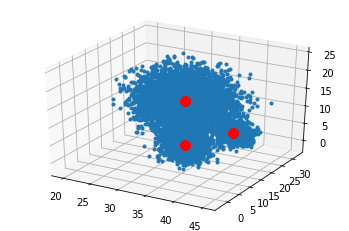

In [17]:
ploting(X_Data.T)
print(mu_org[i][0])
if d == 2:
    [plt.plot(mu_org[i][0],mu_org[i][1], '.', c='r', markersize = 20) for i in range(K)]
if d == 3:
    [plt.plot(mu_org[i][0],mu_org[i][1],mu_org[i][2], '.', c='r', markersize = 20) for i in range(K)]
    


#### Estimated Data:

<Figure size 1440x720 with 0 Axes>

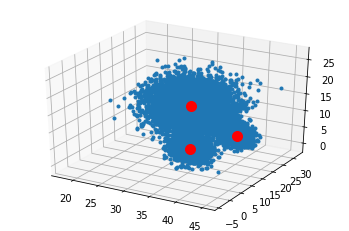

In [18]:
ploting(X_Data_hat)
if d == 2:
    [plt.plot([mu_hat[0,i]],[mu_hat[1,i]], '.', c='r', markersize = 20) for i in range(K)]
if d == 3:
    [plt.plot([mu_hat[0,i]],[mu_hat[1,i]],[mu_hat[2,i]], '.', c='r', markersize = 20) for i in range(K)]